In [174]:
from localgraphclustering import *

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

# Load Protein-Protein interaction graph

In [175]:
# Read graph. This also supports gml and graphml format.
# The MIPS Mammalian Protein-Protein Database is a database for protein-protein interactions of mammalian species. 
# We used the data set proposed in consisting of a subset of 220 protein complexes of 1562 proteins. 
# Details can be found here: https://clusteval.sdu.dk/1/datasets/685
g = graph_class_local.GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')

## Compute layout for visualization

In [176]:
# Add data to graphtool.
g_gtool = Graph(directed=False)
m = g._num_edges

idxs = dict(zip(g.vertices, range(len(g.vertices)))) 
iedges = [(idxs[e[0]], idxs[e[1]]) for e in g.edges] 

for i in range(m):
    g_gtool.add_edge(iedges[i][0], iedges[i][1], add_missing=True)  
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Visualize the PPI graph

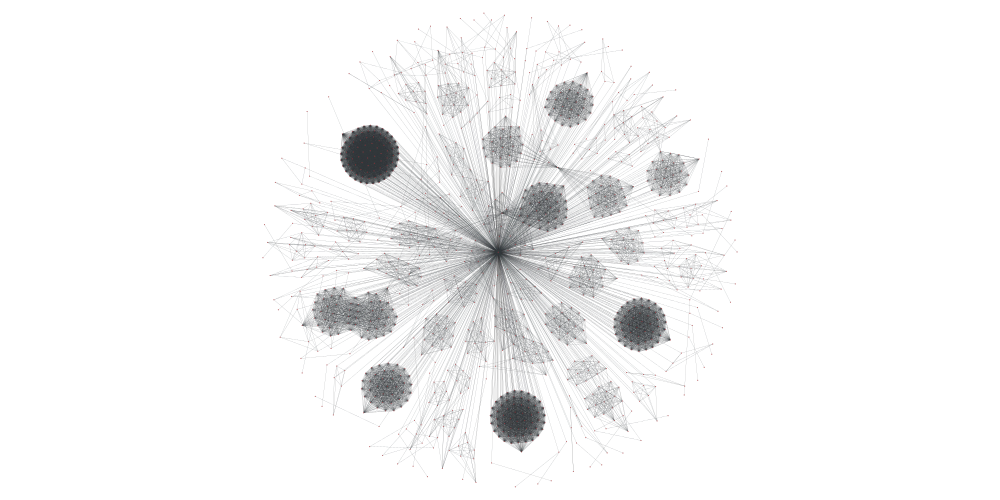

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ad244a8, at 0x13ad1c710>

In [177]:
c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=1, 
           edge_pen_width=0.1,
           vcmap=c_map)

## Localized vector using l1-regularized PageRank

In [178]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = 100
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=4.0e-5)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Visualize the solution

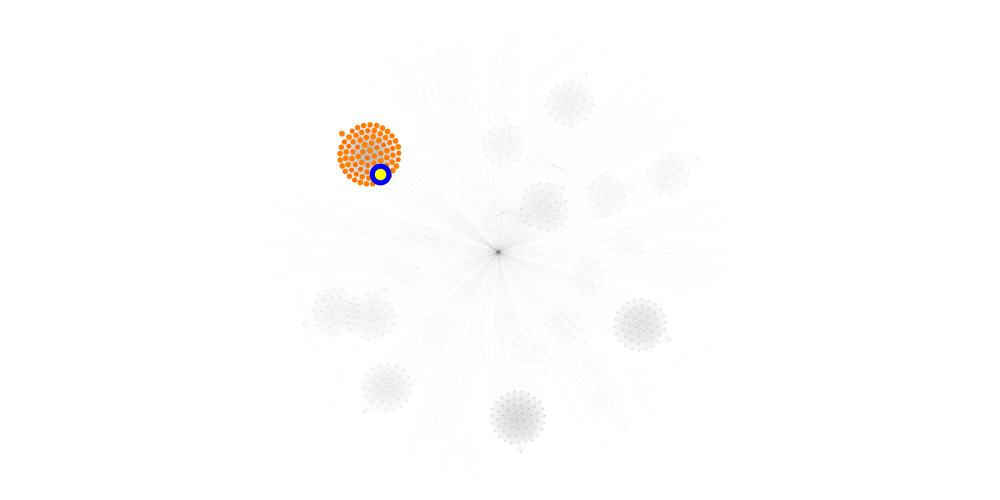

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ad244a8, at 0x13ad1c710>

In [179]:
# Some pre-processing to make visualization better.
temp = np.copy(l1_reg_vector)
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/2.6
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [180]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0][0]

## Visualize local partitioning

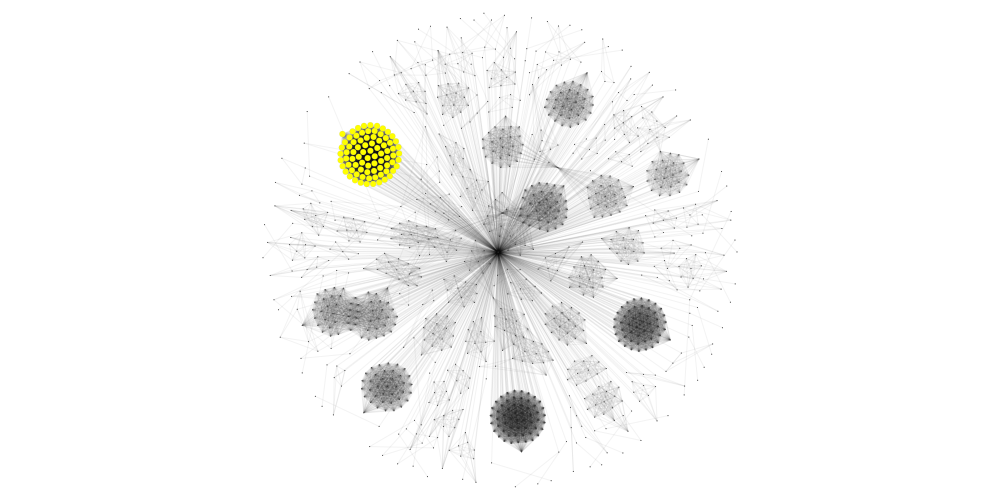

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ad244a8, at 0x13ad1c710>

In [184]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 1

temp[l1_reg_vector_rounded] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05])

# Load Blasted Sequences graph

In [143]:
# Read graph. This also supports gml and graphml format.
# The data set contains pairwise similarities of blasted 
# sequences of 232 proteins belonging to the amidohydrolase superfamily. 
g = graph_class_local.GraphLocal('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml','graphml',' ')

## Compute layout for visualization

In [144]:
# Add data to graphtool.
g_gtool = Graph(directed=False)
m = g._num_edges

idxs = dict(zip(g.vertices, range(len(g.vertices)))) 
iedges = [(idxs[e[0]], idxs[e[1]]) for e in g.edges] 

for i in range(m):
    g_gtool.add_edge(iedges[i][0], iedges[i][1], add_missing=True)  
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_coordinates.xy', dtype = 'str')

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3] 

## Visualize the Blasted Sequences graph

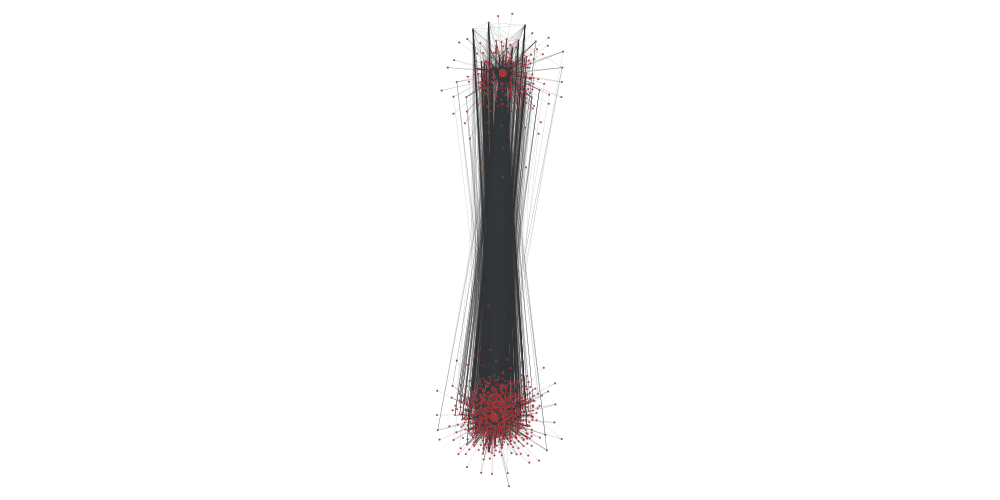

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ec5b320, at 0x13ec3a748>

In [145]:
c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=2, 
           edge_pen_width=0.1,
           vcmap=c_map)

## Localized vector using l1-regularized PageRank

In [146]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = 196
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=5.0e-5)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Visualize the solution

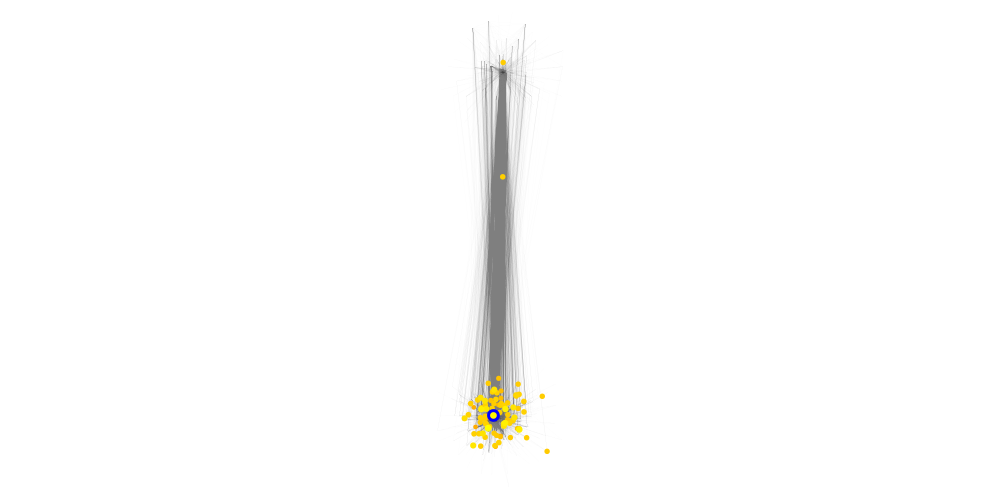

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ec5b320, at 0x13ec3a748>

In [147]:
# Some pre-processing to make visualization better.
temp = np.copy(l1_reg_vector)
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/5
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [148]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0][0]

## Visualize local partitioning

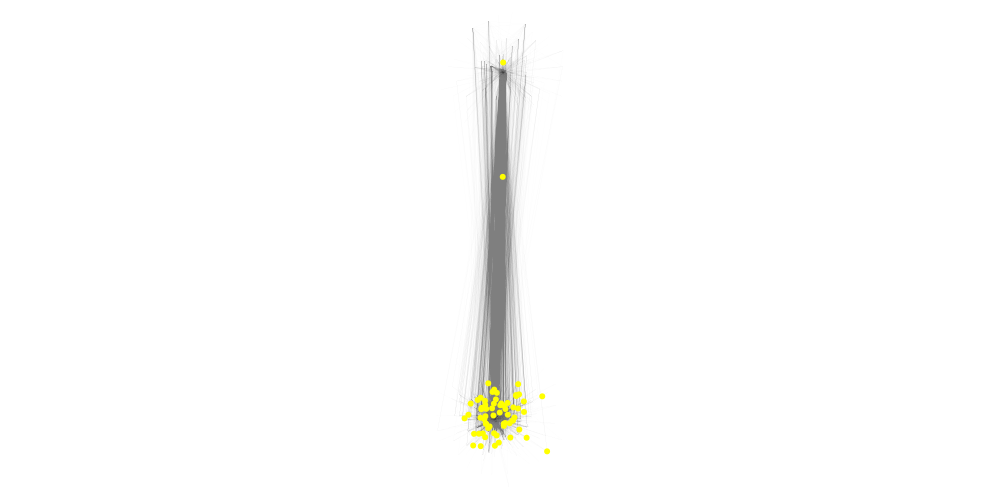

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ec5b320, at 0x13ec3a748>

In [149]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

temp[l1_reg_vector_rounded] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05])

# Load Protein structure similarity graph

In [150]:
# Read graph. This also supports gml and graphml format.
# Details for this dataset can be found here: https://clusteval.sdu.dk/1/datasets/981 
g = graph_class_local.GraphLocal('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2_2.graphml','graphml',' ')

## Compute layout for visualization

In [151]:
# Add data to graphtool.
g_gtool = Graph(directed=False)
m = g._num_edges

idxs = dict(zip(g.vertices, range(len(g.vertices)))) 
iedges = [(idxs[e[0]], idxs[e[1]]) for e in g.edges] 

for i in range(m):
    g_gtool.add_edge(iedges[i][0], iedges[i][1], add_missing=True)  
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2_2.xy', dtype = 'str')

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3] 

## Visualize the graph

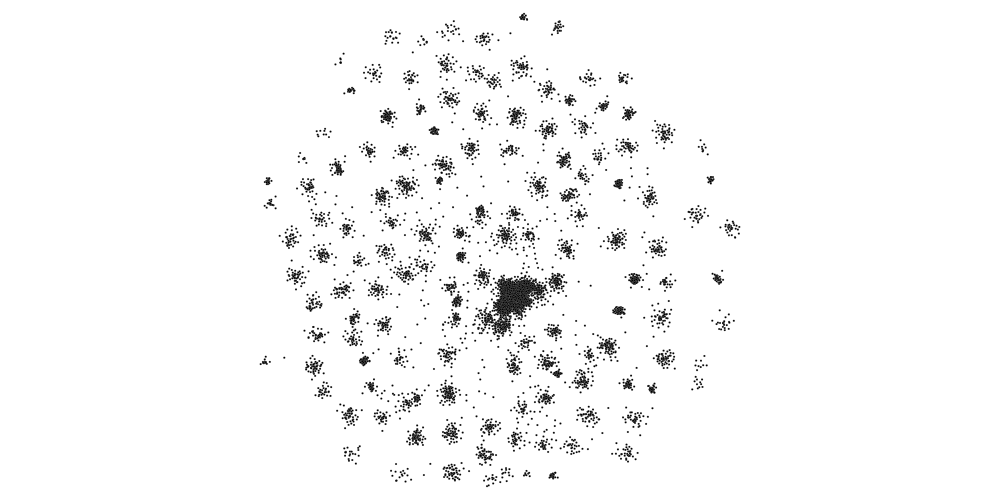

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [152]:
c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=2, 
           vertex_fill_color='black',
           edge_pen_width=0.0,
           vcmap=c_map)

## Localized vector using l1-regularized PageRank

In [153]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
#reference_node = 11192 # Good cluster
#reference_node = 8512 # Not so good
#reference_node = 12819 # Very good cluster
#reference_node = 10459 # Good cluster
reference_node = 13212 # Good cluster
#reference_node = 13319 # Not so good
#reference_node = 8939 # Very good cluster
#reference_node = 6852 # Good cluster
#reference_node = 4359 # Not so good
#reference_node = 9403 # Not so good
#reference_node = 4222 # Very good cluster
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=6.5e-6)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Obtain the partition using the localized vector from l1-regularized PageRank

In [154]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded_1 = output_sc_fast[0][0]

## Visualize local partitioning

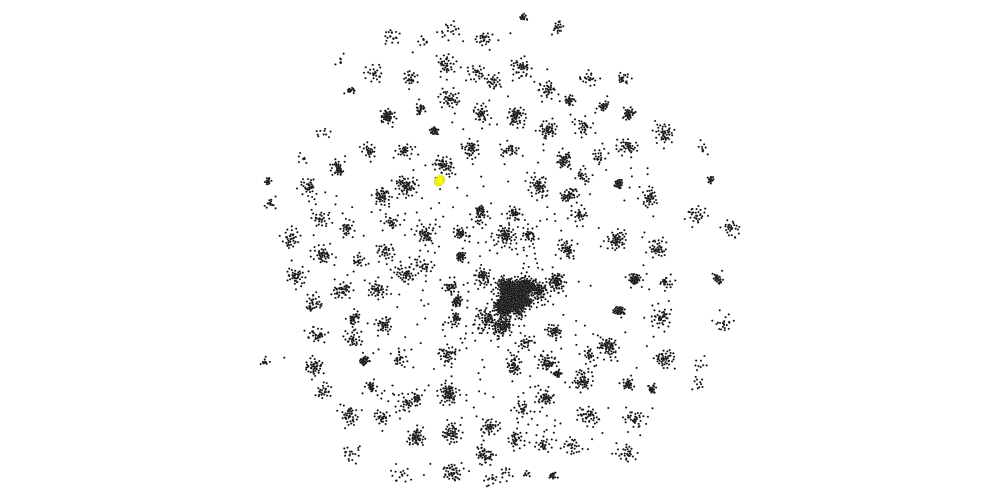

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [155]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 2

temp[l1_reg_vector_rounded_1] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded_1:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05])

## Let us find a better solution of the previous cluster by using Simple Local

In [156]:
# Create an object for subgraph node partitioning.
SL_fast = SimpleLocal_fast.SimpleLocal_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(l1_reg_vector_rounded_1))

# Start calling SimpleLocal
start = time.time()
output_SL_fast = SL_fast.produce([g],[l1_reg_vector_rounded_1])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_SL_fast[0][0]))

output_SL_1 = output_SL_fast[0][0]

Conductance before improvement: 0.664464993395
running time: 0.00648188591003418s
Conductance after improvement: 0.640625


# Visualize the result

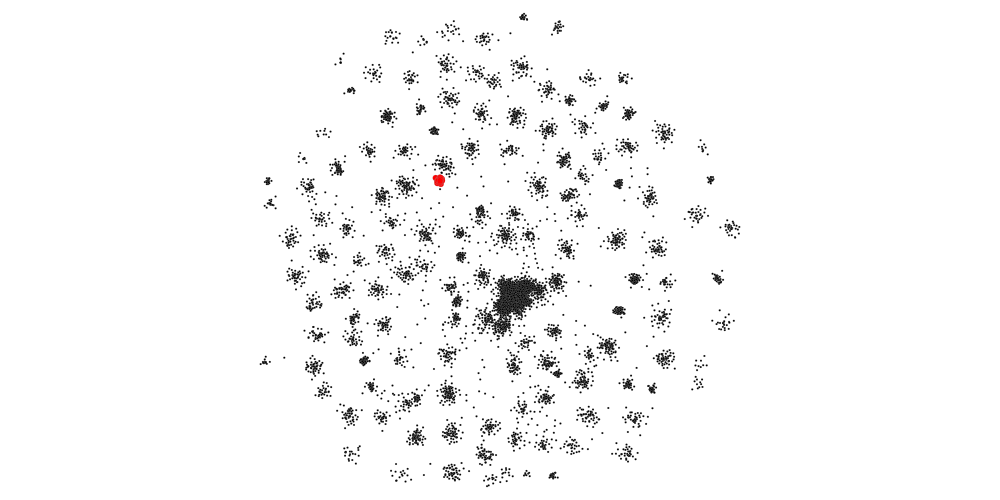

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [157]:
# Visualize the results.
temp = np.zeros(g._num_vertices) + 2

temp[output_SL_1] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL_1:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)

## Localized vector using l1-regularized PageRank

In [158]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
#reference_node = 11192 # Good cluster
#reference_node = 8512 # Not so good
#reference_node = 12819 # Very good cluster
#reference_node = 10459 # Good cluster
#reference_node = 13212 # Good cluster
#reference_node = 13319 # Not so good
#reference_node = 8939 # Very good cluster
#reference_node = 6852 # Good cluster
#reference_node = 4359 # Not so good
#reference_node = 9403 # Not so good
reference_node = 4222 # Very good cluster
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=6.5e-6)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Obtain the partition using the localized vector from l1-regularized PageRank

In [159]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded_2 = output_sc_fast[0][0]

## Visualize local partitioning

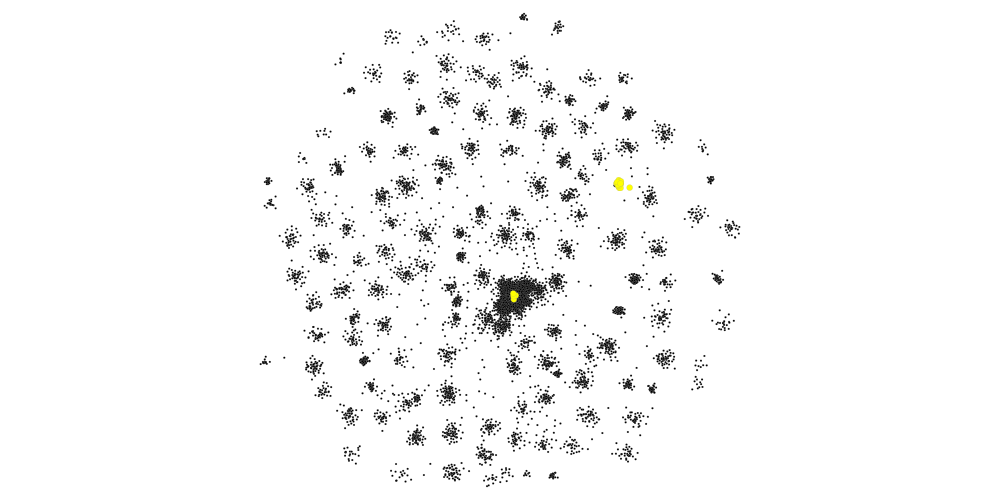

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [160]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 2

temp[l1_reg_vector_rounded_2] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded_2:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05])

## Let us find a better solution of the previous cluster by using Simple Local

In [161]:
# Create an object for subgraph node partitioning.
SL_fast = SimpleLocal_fast.SimpleLocal_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(l1_reg_vector_rounded_2))

# Start calling SimpleLocal
start = time.time()
output_SL_fast = SL_fast.produce([g],[l1_reg_vector_rounded_2])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_SL_fast[0][0]))

output_SL_2 = output_SL_fast[0][0]

Conductance before improvement: 0.616634799235
running time: 0.0220491886138916s
Conductance after improvement: 0.521650682941


# Visualize the result

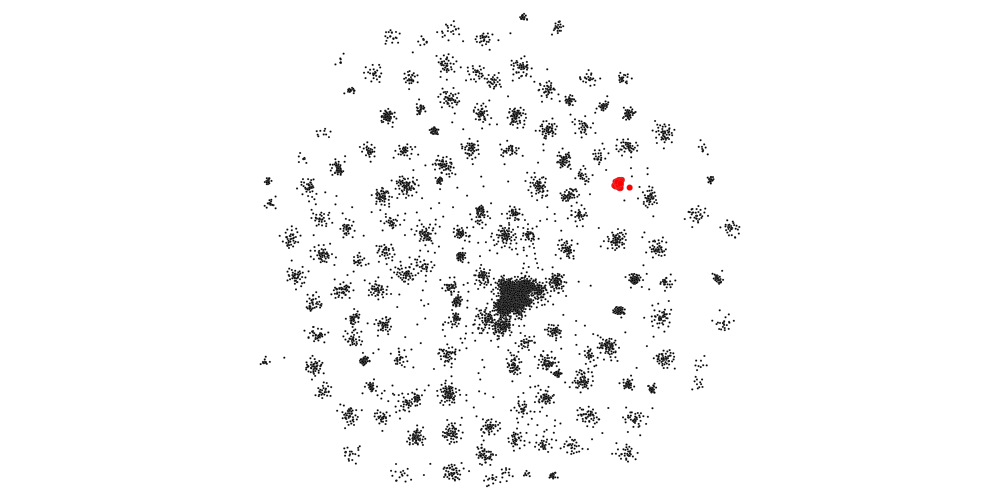

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [162]:
# Visualize the results.
temp = np.zeros(g._num_vertices) + 2

temp[output_SL_2] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL_2:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)

## Localized vector using l1-regularized PageRank

In [163]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
#reference_node = 11192 # Good cluster
#reference_node = 8512 # Not so good
reference_node = 12819 # Very good cluster
#reference_node = 10459 # Good cluster
#reference_node = 13212 # Good cluster
#reference_node = 13319 # Not so good
#reference_node = 8939 # Very good cluster
#reference_node = 6852 # Good cluster
#reference_node = 4359 # Not so good
#reference_node = 9403 # Not so good
#reference_node = 4222 # Very good cluster
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=6.5e-6)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Obtain the partition using the localized vector from l1-regularized PageRank

In [164]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded_3 = output_sc_fast[0][0]

## Visualize local partitioning

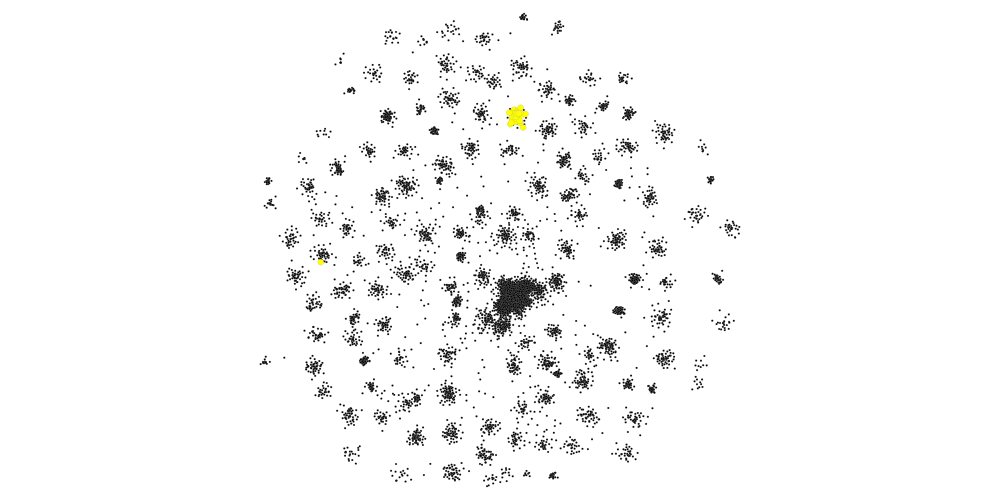

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [165]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 2

temp[l1_reg_vector_rounded_3] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded_3:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05])

## Let us find a better solution of the previous cluster by using Simple Local

In [166]:
# Create an object for subgraph node partitioning.
SL_fast = SimpleLocal_fast.SimpleLocal_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(l1_reg_vector_rounded_3))

# Start calling SimpleLocal
start = time.time()
output_SL_fast = SL_fast.produce([g],[l1_reg_vector_rounded_3])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_SL_fast[0][0]))

output_SL_3 = output_SL_fast[0][0]

Conductance before improvement: 0.636624775583
running time: 0.026123762130737305s
Conductance after improvement: 0.62582486178


# Visualize the result

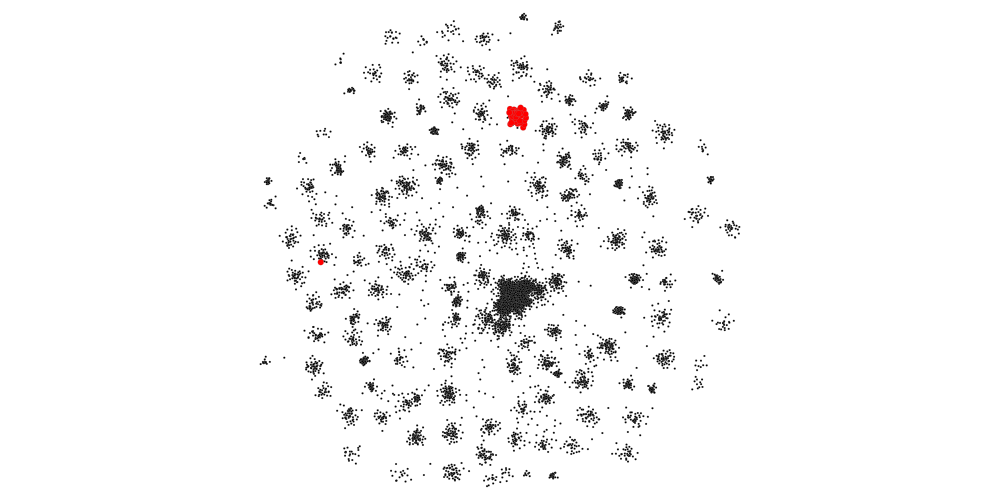

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [167]:
# Visualize the results.
temp = np.zeros(g._num_vertices) + 2

temp[output_SL_3] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL_3:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)

## Localized vector using l1-regularized PageRank

In [168]:
# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
#reference_node = 11192 # Good cluster
#reference_node = 8512 # Not so good
#reference_node = 12819 # Very good cluster
#reference_node = 10459 # Good cluster
#reference_node = 13212 # Good cluster
#reference_node = 13319 # Not so good
reference_node = 8939 # Very good cluster
#reference_node = 6852 # Good cluster
#reference_node = 4359 # Not so good
#reference_node = 9403 # Not so good
#reference_node = 4222 # Very good cluster
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=6.5e-6)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Obtain the partition using the localized vector from l1-regularized PageRank

In [169]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded_4 = output_sc_fast[0][0]

## Visualize local partitioning

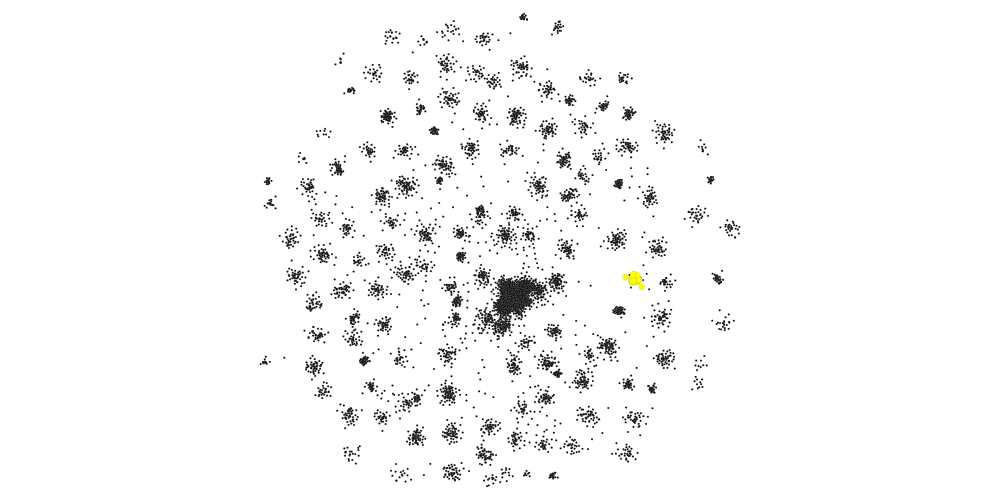

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [170]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 2

temp[l1_reg_vector_rounded_4] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded_4:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05])

## Let us find a better solution of the previous cluster by using Simple Local

In [171]:
# Create an object for subgraph node partitioning.
SL_fast = SimpleLocal_fast.SimpleLocal_fast()

# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(l1_reg_vector_rounded_4))

# Start calling SimpleLocal
start = time.time()
output_SL_fast = SL_fast.produce([g],[l1_reg_vector_rounded_4])
end = time.time()
print("running time:",str(end-start)+"s")

# Conductance after improvement
print("Conductance after improvement:",g.compute_conductance(output_SL_fast[0][0]))

output_SL_4 = output_SL_fast[0][0]

Conductance before improvement: 0.602547016141
running time: 0.028615951538085938s
Conductance after improvement: 0.617350369872


# Visualize the result

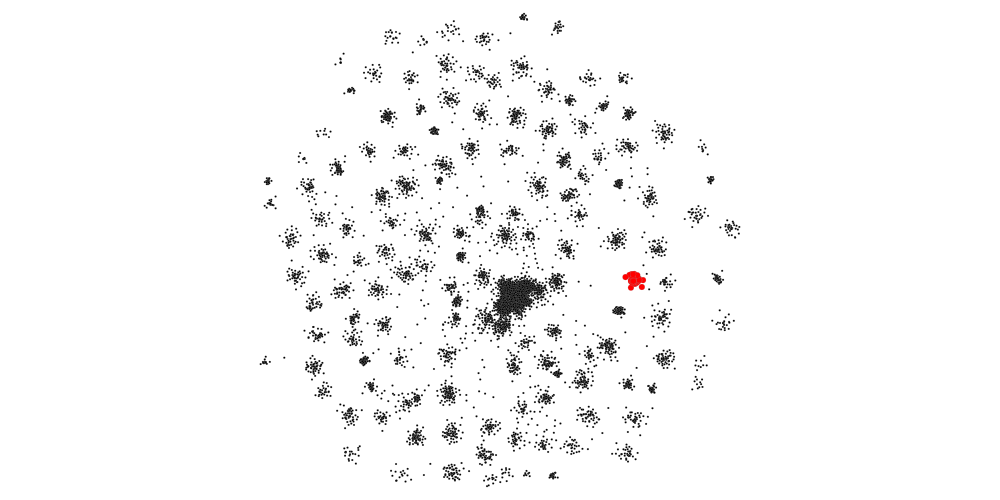

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [172]:
# Visualize the results.
temp = np.zeros(g._num_vertices) + 2

temp[output_SL_4] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL_4:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)

# Visualize all the clusters

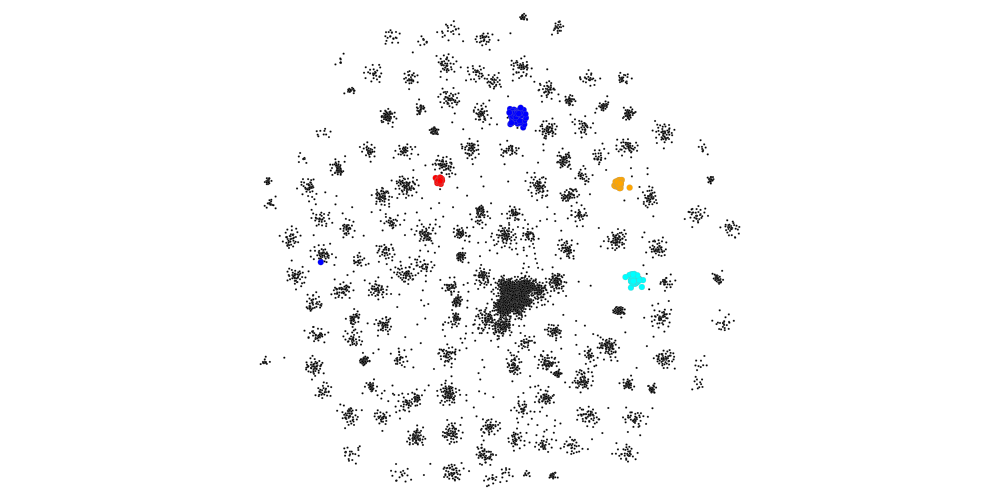

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c1047f0, at 0x13c10b470>

In [173]:
# Visualize the results.
temp = np.zeros(g._num_vertices) + 2

temp[output_SL_1] = 6
temp[output_SL_2] = 6
temp[output_SL_3] = 6
temp[output_SL_4] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_SL_1:
    temp[i] = "red"
for i in output_SL_2:
    temp[i] = "orange"
for i in output_SL_3:
    temp[i] = "blue"
for i in output_SL_4:
    temp[i] = "cyan"
    
node_colours = g_gtool.new_vertex_property("string",temp)  

c_map = plt.get_cmap('autumn')
    
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.0,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map)